# Feature Selection

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import col, sum as _sum, when
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

import seaborn as sns

from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder # Keep for completeness
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split # Best practice for model training




In [0]:
out_path = "dbfs:/student-groups/Group_4_1/otpw_5Y_checkpoint_8/"

df_otpw = spark.read.parquet(out_path)
df_otpw.printSchema()


display(df_otpw.limit(5))



root
 |-- OP_CARRIER_AIRLINE_ID: double (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- ORIGIN_AIRPORT_ID: double (nullable = true)
 |-- DEST_AIRPORT_ID: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- DEP_DELAY_GROUP: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- QUARTER: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- LONG

OP_CARRIER_AIRLINE_ID,YEAR,month,FL_DATE,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_TIME,ORIGIN,HourlyPrecipitation,HourlySeaLevelPressure,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,QUARTER,day_of_week,ELEVATION,LONGITUDE,LATITUDE,ts_date,DISTANCE_GROUP,DISTANCE,CRS_ELAPSED_TIME,HourlyAltimeterSetting,is_us_holiday,is_holiday_window,is_summer_peak,season,is_weekday,hour_of_day,is_weekend,is_superbowl_window,is_GHC_window,is_GHC_Host_Airport_Peak,route_avg_delay_last_7days,origin_avg_delay_last_7days,dest_avg_delay_last_7days,Weather_Index,HourlySkyConditions,CRS_DEP_TIME_SIN,CRS_DEP_TIME_COS,is_disruption_day,is_airport_disrupted,is_federal_shutdown_day,disruption_severity,days_into_disruption,Origin_FlightCount_PR_Scores,Dest_FlightCount_PR_Scores,total_airline_pagerank,avg_airline_pagerank,airline_reputation_score,is_disaster_day,days_since_disaster,disaster_severity,is_CES_window,is_CES_LasVegas_Peak
20366.0,2017,10,2017-10-17,11049.0,12266.0,543.0,CLL,0.0,30.28,-1.0,48.0,29.93,7.0,69.0,43.0,53.0,10.0,4.0,2,93.0,-96.36472,30.58917,2017-10-17T06:53:00,1.0,74.0,44.0,30.29,0,0,0,Fall,1,10,0,0,0,0,8.865270235324541,11.582906913445836,12.24349509928162,1.5564670192960008,clear sky,0.9992290362407229,0.039259815759068666,0,0,0,0,0,6.526194367563096E-4,0.022059251640517672,8961.833934080278,5.4479233641825395,87.3336252189142,0,0,0,0,0
20304.0,2018,4,2018-04-01,10693.0,12266.0,845.0,BNA,0.0,30.13,-1.0,55.0,29.49,7.0,81.0,52.0,58.0,10.0,2.0,7,182.9,-86.68917,36.11889,2018-04-01T09:53:00,3.0,657.0,146.0,30.14,0,0,0,Spring,0,13,1,0,0,0,15.21731242710898,12.792410293080675,12.24349509928162,0.40222187807487914,partly cloudy,0.7402181274868322,-0.6723668074346679,0,0,0,0,0,0.007749515347589402,0.022059251640517672,12125.673179509542,4.8815109418315386,88.96338657726943,0,0,0,0,0
20366.0,2017,10,2017-10-24,11057.0,15412.0,1607.0,CLT,0.0,29.8,-1.0,55.0,28.99,7.0,44.0,44.0,67.0,10.0,4.0,2,221.9,-80.9552,35.2236,2017-10-24T16:52:00,1.0,177.0,60.0,29.81,0,0,0,Fall,1,20,0,0,0,0,16.69372197309417,12.265762010962503,15.140375182536413,-0.7227395278442901,partly cloudy,-0.8968727415326883,-0.44228869021900136,0,0,0,0,0,0.02252367749604308,0.0019158442377230239,8961.833934080278,5.4479233641825395,87.3336252189142,0,0,0,0,0
20366.0,2017,10,2017-10-05,10693.0,12953.0,1833.0,BNA,0.0,30.13,-1.0,63.0,29.49,0.0,66.0,58.0,70.0,10.0,4.0,4,182.9,-86.68917,36.11889,2017-10-05T19:53:00,4.0,764.0,141.0,30.14,0,0,0,Fall,1,23,0,0,1,0,17.773285682376592,12.792410293080675,19.01277193005824,-0.28469779707858034,mostly cloudy,-0.9862856015372314,0.1650476058606778,0,0,0,0,0,0.007749515347589402,0.015474866032023265,8961.833934080278,5.4479233641825395,87.3336252189142,0,0,0,0,0
20366.0,2017,10,2017-10-26,11057.0,12953.0,1427.0,CLT,0.0,29.94,1.0,50.0,29.12,9.0,37.0,36.0,63.0,10.0,4.0,4,221.9,-80.9552,35.2236,2017-10-26T14:52:00,3.0,544.0,118.0,29.94,0,0,0,Fall,1,18,0,0,0,0,17.245918100061118,12.265762010962503,19.01277193005824,0.2566043450112034,clear sky,-0.5000000000000001,-0.8660254037844386,0,0,0,0,0,0.02252367749604308,0.015474866032023265,8961.833934080278,5.4479233641825395,87.3336252189142,0,0,0,0,0


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

# List of columns that need to be cast from string to double
STRING_TO_DOUBLE_COLS = [
    'ELEVATION', 
    'LONGITUDE', 
    'LATITUDE', 
    'DISTANCE', 
    'CRS_ELAPSED_TIME'
]

# Iterate through the list and cast each column
df_otpw_casted = df_otpw

for col_name in STRING_TO_DOUBLE_COLS:
    df_otpw_casted = df_otpw_casted.withColumn(
        col_name,
        # Cast the column to DoubleType
        F.col(col_name).cast(DoubleType())
    )
    
print("Casting complete.")

# Sanity Check: Print the schema to confirm the type change
df_otpw_casted.select(STRING_TO_DOUBLE_COLS).printSchema()

Casting complete.
root
 |-- ELEVATION: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)



In [0]:
from pyspark.sql import functions as F

def drop_all_null_columns(df):
    """
    Identifies and drops columns from a PySpark DataFrame that contain at least one null value.
    
    Args:
        df (DataFrame): The input PySpark DataFrame.
        
    Returns:
        DataFrame: The DataFrame with null-containing columns dropped.
    """
    print("--- Starting Null Column Check ---")
    
    # 1. Calculate the sum of nulls for every column
    # The .collect() action triggers the execution plan.
    null_counts_row = df.select(
        [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]
    ).collect()[0]

    # 2. Identify columns to drop
    cols_to_drop = []
    
    # Check the result row dictionary
    for col_name, null_count in null_counts_row.asDict().items():
        if null_count > 0:
            cols_to_drop.append(col_name)
            print(f"Identified column '{col_name}' with {null_count:,} null values for dropping.")
            
    # 3. Drop the identified columns
    if cols_to_drop:
        df_dropped = df.drop(*cols_to_drop)
        print(f"\nSuccessfully dropped {len(cols_to_drop)} columns.")
        return df_dropped
    else:
        print("\nNo columns containing null values were found. DataFrame remains unchanged.")
        return df

# --- Example Usage ---
# Assuming your DataFrame is df_otpw
df_otpw_cleaned = drop_all_null_columns(df_otpw)

--- Starting Null Column Check ---

No columns containing null values were found. DataFrame remains unchanged.


### Pearson Correlation

In [0]:


# --- 1. Define and Cast Continuous Numeric Columns ---
# List of all numeric-like columns, including those currently stored as string/integer.

ALL_NUMERIC_COLS = [
    # "HourlyPrecipitation", "HourlySeaLevelPressure", "HourlyWetBulbTemperature",
    # "HourlyStationPressure", "HourlyWindSpeed", "HourlyRelativeHumidity",
    # "HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyVisibility",
    # "HourlyAltimeterSetting", 
    "Weather_Index",

    "route_avg_delay_last_7days", "origin_avg_delay_last_7days", "dest_avg_delay_last_7days",

    "is_us_holiday", "is_holiday_window", "is_summer_peak", "is_weekday",
    "is_superbowl_window", "hour_of_day", "is_weekend", "is_CES_window",
    "is_CES_LasVegas_Peak", "is_GHC_window", "is_GHC_Host_Airport_Peak",

    "is_disaster_day", "days_since_disaster", "disaster_severity",
    "is_disruption_day", "is_airport_disrupted", "is_federal_shutdown_day",
    "disruption_severity", "days_into_disruption",

    "day_of_week", "month", "DISTANCE_GROUP", "DISTANCE",
     "CRS_DEP_TIME_SIN", "CRS_DEP_TIME_COS",

     'Origin_FlightCount_PR_Scores',
    'Dest_FlightCount_PR_Scores', 'total_airline_pagerank', 'avg_airline_pagerank', 'airline_reputation_score'
]


# Create a temporary DataFrame where string/integer columns are cast to double
df_corr_ready = df_otpw
for col_name in ALL_NUMERIC_COLS:
    # Safely cast all necessary columns to double
    df_corr_ready = df_corr_ready.withColumn(col_name, F.col(col_name).cast(DoubleType()))


# --- 2. Assemble the Columns into a Single Vector ---
# The PySpark MLlib Correlation function requires the input features to be in a single Vector column.
assembler = VectorAssembler(
    inputCols=ALL_NUMERIC_COLS, 
    outputCol="corr_features_vector"
)
df_vector = assembler.transform(df_corr_ready)


# --- 3. Calculate the Pearson Correlation Matrix ---

# Compute the correlation matrix. 'pearson' is the default method.
# .head() is used to trigger the action and collect the result (a Row object)
matrix = Correlation.corr(df_vector, "corr_features_vector").head() 
correlation_matrix = matrix[0].toArray().astype(float) # Extract the dense vector array and cast to float

# --- 4. Display and Analyze the Results ---

# Convert the NumPy array (from .toArray()) back into a pandas DataFrame 
# for easy reading and visualization.
corr_df = pd.DataFrame(
    correlation_matrix, 
    index=ALL_NUMERIC_COLS, 
    columns=ALL_NUMERIC_COLS
)

print("--- Pearson Correlation Matrix ---")
display(corr_df) # Use display() for Databricks/Jupyter environments

# --- 5. Actionable Insight (Identify highly correlated pairs) ---
print("\n--- Highly Correlated Pairs (r > 0.95) ---")

high_corr_pairs = set()
num_cols = len(ALL_NUMERIC_COLS)

# Iterate through the upper triangle of the matrix to find highly correlated pairs
for i in range(num_cols):
    for j in range(i + 1, num_cols):
        corr_value = correlation_matrix[i, j]
        # Check for strong positive or negative correlation
        if abs(corr_value) > 0.95: 
            col_i = ALL_NUMERIC_COLS[i]
            col_j = ALL_NUMERIC_COLS[j]
            
            # 1. Sort ONLY the column names (strings)
            sorted_cols = tuple(sorted((col_i, col_j)))
            
            # 2. Add the pair and the correlation value to the set
            # This avoids the error and ensures unique pairs regardless of order.
            high_corr_pairs.add(sorted_cols + (round(corr_value, 4),))

for pair in high_corr_pairs:
    # pair is now structured as ('ColA', 'ColB', r_value)
    print(f"**Highly Correlated:** {pair[0]} and {pair[1]} (r = {pair[2]})")

# Guidance: For any pair listed above, drop one of the two features 
# before training your MLP to improve stability.

# Guidance: For any pair listed above, drop one of the two features 
# before training your MLP to improve stability.

--- Pearson Correlation Matrix ---


Weather_Index,route_avg_delay_last_7days,origin_avg_delay_last_7days,dest_avg_delay_last_7days,is_us_holiday,is_holiday_window,is_summer_peak,is_weekday,is_superbowl_window,hour_of_day,is_weekend,is_CES_window,is_CES_LasVegas_Peak,is_GHC_window,is_GHC_Host_Airport_Peak,is_disaster_day,days_since_disaster,disaster_severity,is_disruption_day,is_airport_disrupted,is_federal_shutdown_day,disruption_severity,days_into_disruption,day_of_week,month,DISTANCE_GROUP,DISTANCE,CRS_DEP_TIME_SIN,CRS_DEP_TIME_COS,Origin_FlightCount_PR_Scores,Dest_FlightCount_PR_Scores,total_airline_pagerank,avg_airline_pagerank,airline_reputation_score
1.0,0.014902431212894808,0.029705694587939056,0.0067848241930753605,0.044237206616225634,0.09630309870046964,-0.46358362945590786,0.004730113381956786,0.02749563589375106,-0.07452161174639922,-0.009465017539100116,0.17866522727733428,0.019057220796637974,-0.043432553416822575,-0.02972429297266431,-0.006668195689052675,-0.0039539158956500555,-0.006884607269300557,0.0372153851376813,-0.05603049619606888,0.1340145562592894,0.060814289658750915,-0.02835783870962816,0.0024711433023601698,-0.16394744559060748,-0.03171661478746846,-0.03351354026468736,0.042561771749800234,0.06097178605310441,0.03300599745846372,0.0054781239990916684,0.07469837968782146,0.026762652327430886,0.07747206429671966
0.014902431212894808,1.0,0.5704814775904331,0.6635658991299859,0.0011819405896584187,7.73929237225377E-4,1.6235376062371113E-4,7.938974941378541E-4,-0.006547869094719573,0.02092006645206546,0.001047271971039447,5.706861959475794E-4,2.2776948328145753E-4,3.906180799885279E-4,0.007351337465555444,0.006871487419578554,0.005820202432132573,0.007416073471266179,0.060029890319954385,0.07037565187962769,0.006270645745181135,0.05711668448823472,0.07013730614776985,1.4509170115451433E-4,8.936141300251421E-4,0.09251213815865204,0.09597895541240824,-0.033344644835478054,0.009888217330491092,0.039201358019707845,0.0430502033918671,0.02680928758191639,0.18990174223436462,0.00896048153097017
0.029705694587939056,0.5704814775904331,1.0,0.2242642114323965,4.2439215435535196E-4,2.0459252002334562E-4,-0.004868275653162725,0.0012787453840684255,-0.008284405008446308,0.046306756116298406,2.4194629918314561E-4,0.0013363975969591635,4.880480232079033E-4,5.432500182247321E-4,0.012947623688905653,0.011374236446928454,0.01011163947417446,0.012240803562100704,0.10607787194274872,0.12888060188045522,0.005129566295530208,0.1000292314331008,0.12713073779537132,-1.0870892803872205E-4,-0.0014497508740872436,0.023386749623079066,0.01940784465603847,-0.0037117516844658084,-0.01117730689579888,0.06864730879918148,0.05460156039932387,0.060297362320686894,0.23964384287055984,-0.012504444259228928
0.0067848241930753605,0.6635658991299859,0.2242642114323965,1.0,1.3556120298799834E-5,-0.0012645165178936536,-0.003598628774691916,0.005073427284777655,-0.004888918448477741,0.019184979980158376,-0.00477915966252896,2.544107393672803E-4,-0.0032362352968235523,6.438129320705881E-4,0.005069037687735015,7.64012091308691E-4,1.519096297299843E-4,5.854024817201622E-4,0.0030578020522675524,0.0016863661399937043,0.002708076481217895,0.004095402703454644,0.0015864599726115216,-0.0029000228551686667,3.4917985450322867E-4,0.09075857522125363,0.08797099897768905,0.007010983689764098,0.008776456626229891,0.026946600397530857,0.06483969798683437,0.02153056859007634,0.22046699332358344,0.023509863569179938
0.044237206616225634,0.0011819405896584187,4.2439215435535196E-4,1.3556120298799834E-5,1.0,0.34447772323602377,-0.046670218803519105,0.06439439157236357,-0.005124906028046467,0.0015890537896169916,-0.07691165995457912,0.004468874825957607,3.4156678632717353E-4,-0.023105131068562892,-0.004765214403847008,8.757806600597701E-4,0.005218263201418842,9.169399283350771E-4,0.03547237710238483,-0.004785848104744704,0.06403467280061555,0.04334574709738591,4.634859882752567E-4,-0.12009749225430118,-0.037330831177382645,0.004208567699015798,0.004276412166912841,8.61004325598549E-4,-0.006479358904


--- Highly Correlated Pairs (r > 0.95) ---
**Highly Correlated:** disaster_severity and is_disaster_day (r = 0.9874)
**Highly Correlated:** DISTANCE and DISTANCE_GROUP (r = 0.9882)
**Highly Correlated:** disruption_severity and is_disruption_day (r = 0.9792)


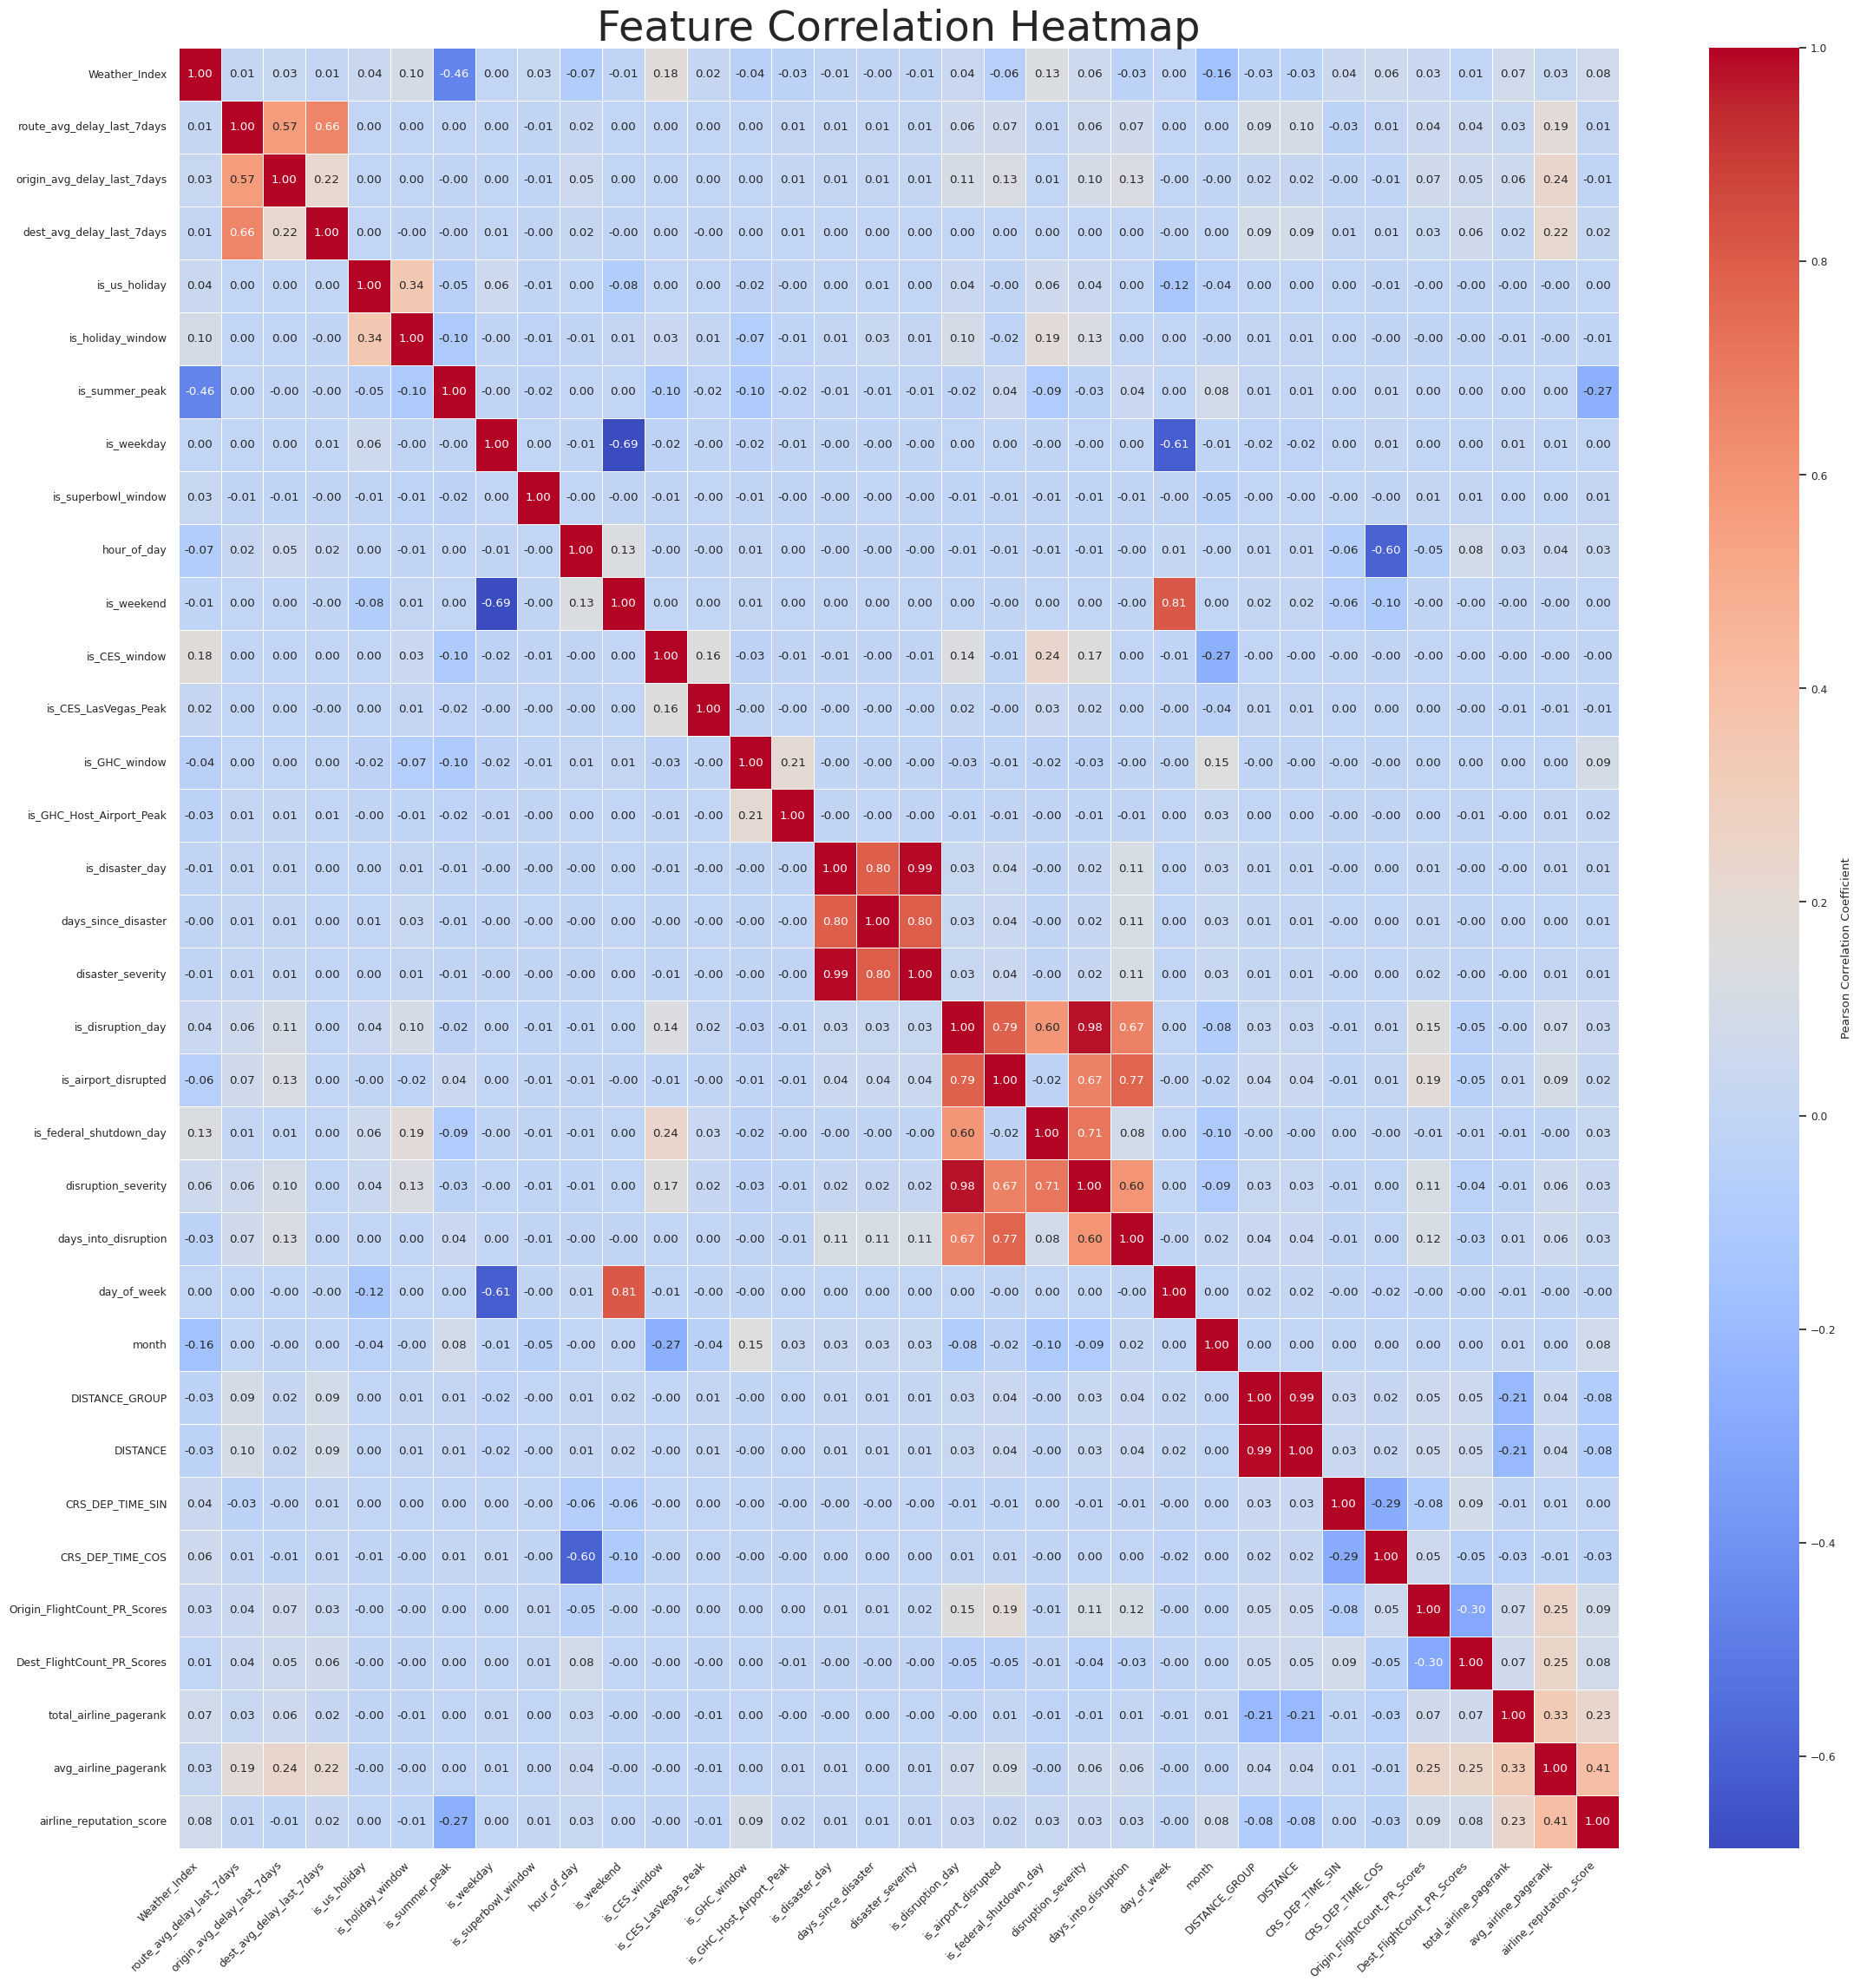

In [0]:


# --- 1. Set Plotting Parameters ---
# Determine the number of features (N)
N = len(corr_df.columns)

# Set a dynamic size: A good rule of thumb is 0.7 * N for height and width
# For ~25 features, this makes the figure roughly 17x17 inches.
fig_size = max(10, int(N * 0.7)) 

plt.figure(figsize=(fig_size, fig_size)) 

# Temporarily increase the global font scale for better readability of annotations
# This scales all labels and annotations within this plot.
sns.set(font_scale=0.8) 

# 2. Plot the Heatmap
sns.heatmap(
    corr_df,
    annot=True,              # Show the correlation values on the map
    fmt=".2f",               # Format to 2 decimal places
    cmap='coolwarm',         # Excellent color scheme for correlation (-1 to +1)
    linewidths=.5,           # Add lines between cells for separation
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)

# 3. Enhance Readability
plt.title('Feature Correlation Heatmap', fontsize=fig_size * 1.5)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right') # Rotate X-axis labels to prevent overlap
plt.tight_layout() # Automatically adjust plot parameters for tight layout

# Reset font scale after plotting to avoid affecting other charts
sns.set(font_scale=1.0) 

# Display the plot in the notebook
plt.show()

In [0]:
# List of highly redundant columns to drop based on the correlation analysis
REDUNDANT_COLS_TO_DROP = [
    "DISTANCE_GROUP",            # Redundant with continuous DISTANCE
    "is_disruption_day",         # Redundant with disruption_severity
    "is_disaster_day"            # Redundant with disaster_severity
]

# Drop the columns from the DataFrame
df_pruned = df_otpw.drop(*REDUNDANT_COLS_TO_DROP)

print(f"Successfully dropped {len(REDUNDANT_COLS_TO_DROP)} redundant columns.")
print("The DataFrame is now pruned and ready for the final feature assembly and scaling steps.")

# Check the schema to confirm the removal
df_pruned.printSchema()

Successfully dropped 3 redundant columns.
The DataFrame is now pruned and ready for the final feature assembly and scaling steps.
root
 |-- OP_CARRIER_AIRLINE_ID: double (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- ORIGIN_AIRPORT_ID: double (nullable = true)
 |-- DEST_AIRPORT_ID: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- DEP_DELAY_GROUP: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-

### ANOVA F-test 

In [0]:
from pyspark.sql import functions as F
from scipy import stats
import pandas as pd

# --- 1. Define Columns and Binarize the Target ---

# Define the continuous features to test.
CONTINUOUS_COLS_TO_TEST = [
    # 1. Continuous Features (Weather)
    'HourlyPrecipitation', 
    'HourlySeaLevelPressure', 
    'HourlyWindSpeed', 
    'HourlyRelativeHumidity', 
    'HourlyDewPointTemperature', 
    'HourlyDryBulbTemperature', 
    'HourlyVisibility', 
    'HourlyAltimeterSetting', 
    
    # 1. Continuous Features (Location/Distance)
    'ELEVATION', 
    'LONGITUDE', 
    'LATITUDE', 
    'DISTANCE', 
    
    # 2. Engineered & Aggregated Features
    'route_avg_delay_last_7days', 
    'origin_avg_delay_last_7days', 
    'dest_avg_delay_last_7days', 
    'Weather_Index', 
    'CRS_DEP_TIME_SIN', 
    'CRS_DEP_TIME_COS', 
    
    # 3. Ordinal & Count Features
    'day_of_week', 
    'month', 
    'hour_of_day', 
    'days_since_disaster', 
    'disaster_severity', 
    'disruption_severity', 
    'days_into_disruption',
    'Origin_FlightCount_PR_Scores',
    'Dest_FlightCount_PR_Scores', 'total_airline_pagerank', 'avg_airline_pagerank', 'airline_reputation_score'
]
TARGET_COL = "DEP_DELAY_GROUP"

# Create the binary target column: 1 if delayed, 0 if not delayed.
df_anova = df_pruned.withColumn(
    "DEP_DELAY_GROUP", 
    F.when(F.col(TARGET_COL).isin([-1, 0]), 0).otherwise(1).cast("int")
)


SAMPLE_FRACTION = 0.037

# B. Create the sampling map (ensures we get a proportional representation of each class)
# We sample 3.7% of the '0' class and 3.7% of the '1' class.
sampling_map = {0: SAMPLE_FRACTION, 1: SAMPLE_FRACTION}

# C. Perform Stratified Sampling
df_sample = df_anova.sampleBy(
    "DEP_DELAY_GROUP", 
    fractions=sampling_map, 
    seed=42 # Use a seed for reproducibility
)

# D. Verify sample size (Optional Action)
sample_count = df_sample.count()
print(f"Sample created with {sample_count:,} rows.")


# --- 2. Function to Calculate F-statistic and p-value ---

def calculate_anova_f_test(df, feature_col):
    """
    Calculates the F-statistic and p-value for a continuous feature 
    against the binary 'DEP_DELAY_GROUP' target using PySpark and SciPy.
    """
    # 1. Collect the feature values grouped by the target class
    # Cast to double to ensure proper statistics
    feature_values = df[['DEP_DELAY_GROUP', feature_col]].dropna().values.tolist()
    
    # 2. Separate values into the two groups (Not Delayed and Delayed)
    group_0 = [row[1] for row in feature_values if row[0] == 0 and row[1] is not None] # Not Delayed
    group_1 = [row[1] for row in feature_values if row[0] == 1 and row[1] is not None] # Delayed

    if len(group_0) < 2 or len(group_1) < 2:
        return None, None # Not enough data in one group to calculate variance

    # 3. Use scipy.stats.f_oneway to perform the ANOVA test
    # Note: f_oneway is a one-way ANOVA test, perfect for 2 groups.
    f_statistic, p_value = stats.f_oneway(group_0, group_1)
    
    return f_statistic, p_value

# --- 3. Run the Test and Collect Results ---

anova_results = []
df_sample_pandas = df_sample.toPandas() # Better to collect once to Pandas if iterating features

for feature in CONTINUOUS_COLS_TO_TEST:
    # Pass the Pandas DataFrame directly to the function if possible, 
    # or ensure the PySpark function uses the collected data from df_sample.
    f_stat, p_val = calculate_anova_f_test(df_sample_pandas, feature) 
    
    if f_stat is not None:
        anova_results.append({
            'Feature': feature,
            'F_Statistic': f_stat,
            'P_Value': p_val,
            'Significance': 'Reject Null (Keep)' if p_val < 0.05 else 'Fail to Reject (Drop)'
        })

# Convert results to a Pandas DataFrame for display
results_df = pd.DataFrame(anova_results).sort_values(by='F_Statistic', ascending=False)


# --- 4. Display Results and Feature Selection Guidance ---

print("--- ANOVA F-Test Results for Continuous Features ---")
print("Target: 'is_delayed' (0: Not Delayed, 1: Delayed)")
display(results_df)

print("\n--- Feature Selection Guidance ---")
print("Features with the highest F-Statistic and a P_Value < 0.05 are the most useful.")
print("Consider dropping features with a low F-Statistic and P_Value > 0.05.")

Sample created with 1,123,627 rows.
--- ANOVA F-Test Results for Continuous Features ---
Target: 'is_delayed' (0: Not Delayed, 1: Delayed)


Feature,F_Statistic,P_Value,Significance
CRS_DEP_TIME_SIN,34467.50008296791,0.0,Reject Null (Keep)
route_avg_delay_last_7days,12912.857511476548,0.0,Reject Null (Keep)
airline_reputation_score,11849.377301795636,0.0,Reject Null (Keep)
CRS_DEP_TIME_COS,5697.571581205819,0.0,Reject Null (Keep)
dest_avg_delay_last_7days,5051.5876910141205,0.0,Reject Null (Keep)
origin_avg_delay_last_7days,4133.248011506518,0.0,Reject Null (Keep)
HourlyRelativeHumidity,3848.9444988393375,0.0,Reject Null (Keep)
HourlyAltimeterSetting,3241.2094620676176,0.0,Reject Null (Keep)
HourlySeaLevelPressure,2193.743941304217,0.0,Reject Null (Keep)
HourlyPrecipitation,1506.2805286055034,0.0,Reject Null (Keep)



--- Feature Selection Guidance ---
Features with the highest F-Statistic and a P_Value < 0.05 are the most useful.
Consider dropping features with a low F-Statistic and P_Value > 0.05.


In [0]:
# List of highly redundant columns to drop based on the correlation analysis
COLS_TO_DROP = [
    "LATITUDE", #  P_Value > 0.05
    "hour_of_day",
    "days_since_disaster",
    "disaster_severity"
    ""
]

# Drop the columns from the DataFrame
df_pruned = df_pruned.drop(*REDUNDANT_COLS_TO_DROP)

print(f"Successfully dropped {len(REDUNDANT_COLS_TO_DROP)} redundant columns.")
print("The DataFrame is now pruned and ready for the final feature assembly and scaling steps.")

# Check the schema to confirm the removal
df_pruned.printSchema()

Successfully dropped 3 redundant columns.
The DataFrame is now pruned and ready for the final feature assembly and scaling steps.
root
 |-- OP_CARRIER_AIRLINE_ID: double (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- ORIGIN_AIRPORT_ID: double (nullable = true)
 |-- DEST_AIRPORT_ID: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- DEP_DELAY_GROUP: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-

In [0]:

out_path = "dbfs:/student-groups/Group_4_1/otpw_5Y_checkpoint_9/"


spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# Create folder (optional)
dbutils.fs.mkdirs(out_path)
# Write parquet in parallel (fast, distributed)
df_pruned.write.mode("overwrite").parquet(out_path)
print("Parquet write completed successfully at:", out_path)



Parquet write completed successfully at: dbfs:/student-groups/Group_4_1/otpw_5Y_checkpoint_9/


### XGBoost feature importance

In [0]:
# drop below groups 

#FL_DATE (we already have month, day_of_week, hour_of_day, etc.)

#ts_date (string timestamp version of the same thing)

COLS_TO_DROP = [
    "FL_DATE" ,
    "ts_date",
]

# Drop the columns from the DataFrame
df_pruned = df_pruned.drop(*REDUNDANT_COLS_TO_DROP)

In [0]:


# 1. Start from your cleaned DF
df = df_pruned # Assuming df_otpw holds the final cleaned DataFrame

df= df.withColumn(
    "is_delayed", 
    F.when(F.col("DEP_DELAY_GROUP").isin([-1, 0]), 0)  # Defines the condition for being "On-Time"
    .otherwise(1)                                    # Anything else (groups 1, 2, 3, etc.) is "Delayed"
    .cast("double")                                  # Casts the result to double (or integer)
)

# 2. Define target and feature lists (Cleaning up features based on previous steps)
target_col = "is_delayed"

# NOTE: OP_CARRIER_AIRLINE_ID is a strong categorical feature, moving from num_cols to cat_cols
cat_cols = [
    "OP_CARRIER_AIRLINE_ID", # Added
    "ORIGIN",
    "DEST_AIRPORT_ID",       # ORIGIN_AIRPORT_ID is often redundant with ORIGIN, kept DEST_AIRPORT_ID
    "HourlySkyConditions",
    "day_of_week",           # Moving to categorical/ordinal
    "month",                 # Moving to categorical/ordinal
    "hour_of_day",           # Moving to categorical/ordinal
]

# NOTE: Removed redundant/superseded features (ELEVATION, LATITUDE, LONGITUDE, etc. based on previous analysis)
num_cols = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "DISTANCE",
    "CRS_ELAPSED_TIME",       # Added (Missing from original list)
    "HourlyAltimeterSetting",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "is_weekday",
    "is_weekend",             # Added (Missing from original list)
    "is_superbowl_window",
    "is_GHC_window",
    "is_GHC_Host_Airport_Peak",
    "route_avg_delay_last_7days",
    "origin_avg_delay_last_7days",
    "dest_avg_delay_last_7days",
    "Weather_Index",
    "CRS_DEP_TIME_SIN",
    "CRS_DEP_TIME_COS",
    "days_since_disaster",
    "disaster_severity",
    "disruption_severity",
    "days_into_disruption",
    'Origin_FlightCount_PR_Scores',
    'Dest_FlightCount_PR_Scores',
    'total_airline_pagerank',
    'avg_airline_pagerank',
    'airline_reputation_score'
]
feature_cols = cat_cols + num_cols

# 3. Cast label and numeric columns to proper types in Spark
# Use F.col(c).cast("double") for ALL numeric features and target
df_prep = df.select([target_col] + feature_cols) \
            .withColumn(target_col, F.col(target_col).cast("int"))

for c in feature_cols: # FIX 1: Cast all features (cat and num) to string/double for toPandas consistency
    if c in num_cols:
        df_prep = df_prep.withColumn(c, F.col(c).cast("double"))
    else:
        df_prep = df_prep.withColumn(c, F.col(c).cast("string"))


# 4. Sample down for XGBoost so toPandas() is safe
# FIX 2: Added .fillna(0) before sampling to prevent NaN errors in toPandas/XGBoost
df_sample = df_prep.fillna(0, subset=num_cols).sample(fraction=0.05, seed=42)

# FIX 3: Dropping QUARTER and ORIGIN_AIRPORT_ID here as they were missing in the final list
# The original code's feature list was inconsistent with the final schema.
pdf = df_sample.toPandas().dropna(subset=[target_col])


# 5. Encode categoricals as integer codes (label encoding)
for c in cat_cols:
    # FIX 4: Robust Label Encoding - handles non-string types and explicitly maps to integers
    pdf[c] = pdf[c].astype("category").cat.codes - pdf[c].astype("category").cat.codes.min()
    # Ensures codes start at 0 if min() isn't 0.

# 6. Build X, y for XGBoost
X = pdf[feature_cols].values
y = pdf[target_col].values

# 7. Split data before training (Best Practice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 8. Train a quick XGBoost model (for importance only)
# FIX 5: Explicitly set num_class based on the max value of DEP_DELAY_GROUP + 1
num_classes = int(np.max(y_train)) + 1 
print(f"Training XGBoost with {num_classes} classes.")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss", # Added better metric for multi-class
    num_class=num_classes   # FIX 6: Required for multi:softprob objective
)

# Use the training split for fitting
model.fit(X_train, y_train)

# 9. Get feature importance
importances = model.feature_importances_

feat_importance = (
    pd.DataFrame({"feature": feature_cols, "importance": importances})
    .sort_values("importance", ascending=False)
)

print("\n--- Top 20 Feature Importances ---")
display(feat_importance.head(20)) # Assuming 'display' function is available (Databricks/Jupyter)

Training XGBoost with 2 classes.

--- Top 20 Feature Importances ---


feature,importance
CRS_DEP_TIME_SIN,0.25271192
airline_reputation_score,0.073093854
route_avg_delay_last_7days,0.06095818
is_summer_peak,0.05689944
HourlyRelativeHumidity,0.046452116
CRS_DEP_TIME_COS,0.028757485
OP_CARRIER_AIRLINE_ID,0.027392508
hour_of_day,0.024646474
dest_avg_delay_last_7days,0.023547528
HourlyPrecipitation,0.023025753


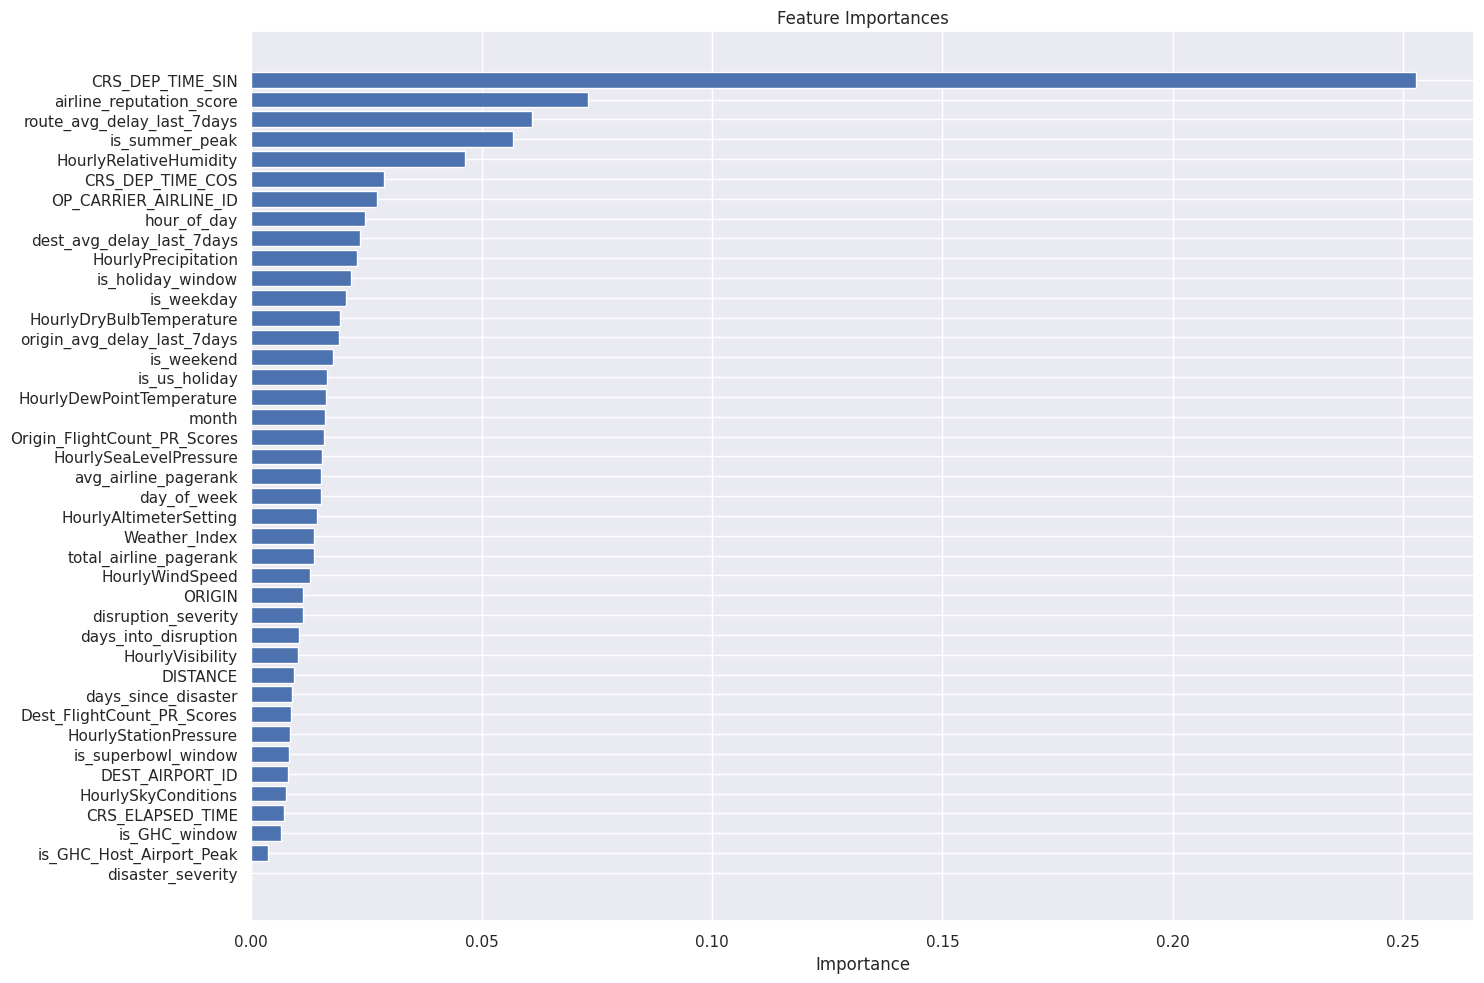

In [0]:
import matplotlib.pyplot as plt

top = (
    feat_importance
    .sort_values("importance", ascending=False)
    .sort_values("importance")   # for horizontal bar order
)

plt.figure(figsize=(15, 10))
plt.barh(top["feature"], top["importance"])
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


### End of Feature Selection